#  Amazon Yorumları için Duygu Analizi

## İş Problemi
Amazon üzerinden satışlarını gerçekleştiren ev tesktili ve günlük giyim odaklı üretimler yapan Kozmos
ürünlerine gelen yorumları analiz ederek ve aldığı şikayetlere göre özelliklerini geliştirerek satışlarını
artırmayı hedeflemektedir. Bu hedef doğrultusunda yorumlara duygu analizi yapılarak etiketlencek ve
etiketlenen veri ile sınıflandırma modeli oluşturulacaktır.

## Veri Seti Hikayesi
Veri seti belirli bir ürün grubuna ait yapılan yorumları, yorum başlığını, yıldız sayısını ve yapılan yorumu
kaç kişinin faydalı bulduğunu belirten değişkenlerden oluşmaktadır.
- Star : Ürüne verilen yıldız sayısı
- HelpFul : Yorumu faydalı bulan kişi sayısı
- Title : Yorum içeriğine verilen başlık, kısa yorum
- Review : Ürüne yapılan yorum

In [1]:

# !pip install nltk
# !pip install textblob
# !pip install wordcloud
from warnings import filterwarnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate
from sklearn.preprocessing import LabelEncoder
from textblob import Word, TextBlob
from wordcloud import WordCloud

filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Görev 1: Metin Ön İşleme

Adım 1: amazon.xlsx verisini okutunuz.

In [6]:
df = pd.read_excel('datasets/amazon.xlsx')
df.head()

,Star,HelpFul,Title,Review
0,5,0,looks great,Happy with it
1,5,0,Pattern did not align between the two panels.,Good quality material however the panels are m...
2,5,0,Imagery is stretched. Still fun.,Product was fun for bedroom windows.<br />Imag...
3,5,0,Que se ven elegantes muy finas,Lo unico que me gustaria es que sean un poco ...
4,5,0,Wow great purchase,Great bang for the buck I can't believe the qu...


Adım 2: Review değişkeni üzerinde ;

a. Tüm harfleri küçük harfe çeviriniz.

In [7]:
df["Review"] = df["Review"].str.lower()

b. Noktalama işaretlerini çıkarınız.

In [8]:
df['Review'] = df['Review'].str.replace('[^\w\s]', '')

c. Yorumlarda bulunan sayısal ifadeleri çıkarınız.

In [9]:
df['Review'] = df['Review'].str.replace('\d', '')

d. Bilgi içermeyen kelimeleri (stopwords) veriden çıkarınız.

In [10]:
sw = stopwords.words('english')
df['Review'] = df['Review'].apply(lambda x: " ".join(x for x in str(x).split() if x not in sw))

e. 1000'den az geçen kelimeleri veriden çıkarınız.

In [11]:
drops = pd.Series(' '.join(df['Review']).split()).value_counts()[-1000:]
df['Review'] = df['Review'].apply(lambda x: " ".join(x for x in x.split() if x not in drops))

f. Lemmatization işlemini uygulayınız.

In [12]:
df['Review'] = df['Review'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

# Görev 2 : Metin Görselleştirme

Adım 1: Barplot görselleştirme işlemi için;

a. "Review" değişkeninin içerdiği kelimeleri frekanslarını hesaplayınız, tf olarak kaydediniz

In [13]:
tf = df["Review"].apply(lambda x: pd.value_counts(x.split(" "))).sum(axis=0).reset_index()

b. tf dataframe'inin sütunlarını yeniden adlandırınız: "words", "tf" şeklinde

In [14]:
tf.columns = ["words", "tf"]

tf.sort_values("tf", ascending=False)

,words,tf
66,curtain,2588.00
42,look,1531.00
120,love,1453.00
104,room,1129.00
166,like,1053.00
...,...,...
2876,unwuiness,1.00
2878,enters,1.00
2879,soonbrlittle,1.00
2880,isbrbrlove,1.00


c. "tf" değişkeninin değeri 500'den çok olanlara göre filtreleme işlemi yaparak barplot ile görselleştirme işlemini
tamamlayınız.

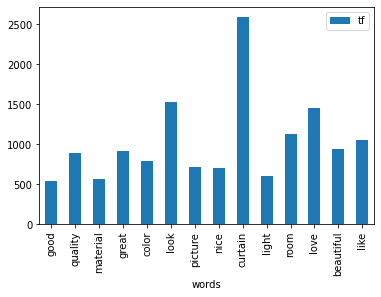

In [15]:
tf[tf["tf"] > 500].plot.bar(x="words", y="tf")
plt.show()

Adım 2: WordCloud görselleştirme işlemi için;

a. "Review" değişkeninin içerdiği tüm kelimeleri "text" isminde string olarak kaydediniz.

In [16]:
text = " ".join(i for i in df.Review)


b. WordCloud kullanarak şablon şeklinizi belirleyip kaydediniz.

In [17]:
wordcloud = WordCloud(background_color="white",
               max_words=1000,
               contour_width=3,
               contour_color="firebrick")


c. Kaydettiğiniz wordcloud'u ilk adımda oluşturduğunuz string ile generate ediniz.

In [18]:
wordcloud = wordcloud.generate(text)


d. Görselleştirme adımlarını tamamlayınız. (figure, imshow, axis, show)

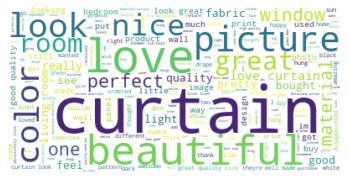

In [19]:
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# Görev 3 : Duygu Analizi

Adım 1: Python içerisindeki NLTK paketinde tanımlanmış olan SentimentIntensityAnalyzer nesnesini oluşturunuz.

In [20]:
sia = SentimentIntensityAnalyzer()

Adım 2: SentimentIntensityAnalyzer nesnesi ile polarite puanlarının inceleyiniz;

a. "Review" değişkeninin ilk 10 gözlemi için polarity_scores() hesaplayınız.

In [21]:
df["Review"][0:10].apply(lambda x: sia.polarity_scores(x))

0    {'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound...
1    {'neg': 0.0, 'neu': 0.633, 'pos': 0.367, 'comp...
2    {'neg': 0.0, 'neu': 0.647, 'pos': 0.353, 'comp...
3    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
4    {'neg': 0.0, 'neu': 0.517, 'pos': 0.483, 'comp...
5    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
6    {'neg': 0.0, 'neu': 0.631, 'pos': 0.369, 'comp...
7    {'neg': 0.0, 'neu': 0.578, 'pos': 0.422, 'comp...
8    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
9    {'neg': 0.0, 'neu': 0.772, 'pos': 0.228, 'comp...
Name: Review, dtype: object

b. İncelenen ilk 10 gözlem için compund skorlarına göre filtrelenerek tekrar gözlemleyiniz.

In [22]:
df["Review"][0:10].apply(lambda x: sia.polarity_scores(x)["compound"])

0   0.57
1   0.44
2   0.72
3   0.00
4   0.90
5   0.00
6   0.62
7   0.91
8   0.00
9   0.71
Name: Review, dtype: float64

c. 10 gözlem için compound skorları 0'dan büyükse "pos" değilse "neg" şeklinde güncelleyiniz.

In [23]:
df["Review"][0:10].apply(lambda x: "pos" if sia.polarity_scores(x)["compound"] > 0 else "neg")

0    pos
1    pos
2    pos
3    neg
4    pos
5    neg
6    pos
7    pos
8    neg
9    pos
Name: Review, dtype: object

d. "Review" değişkenindeki tüm gözlemler için pos-neg atamasını yaparak yeni bir değişken olarak dataframe'e
ekleyiniz.

In [24]:
df["sentiment_label"] = df["Review"].apply(lambda x: "pos" if sia.polarity_scores(x)["compound"] > 0 else "neg")
df["sentiment_label"].value_counts()

pos    4764
neg     847
Name: sentiment_label, dtype: int64

# Görev 4 : Makine Öğrenmesine Hazırlık

Adım 1: Bağımlı ve bağımsız değişkenlerimizi belirleyerek datayı train test olarak ayırınız.

In [26]:
from sklearn.model_selection import train_test_split
y = df["sentiment_label"]
y.value_counts()

pos    4764
neg     847
Name: sentiment_label, dtype: int64

In [27]:
X = df["Review"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=17)

Adım 2: Makine öğrenmesi modeline verileri verebilmemiz için temsil şekillerini sayısala çevirmemiz gerekmekte;

a. TfidfVectorizer kullanarak bir nesne oluşturunuz.

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
tf_idf_word_vectorizer = TfidfVectorizer()

b. Daha önce ayırmış olduğumuz train datamızı kullanarak oluşturduğumuz nesneye fit ediniz.

In [31]:
tf_idf_word_vectorizer = TfidfVectorizer().fit(X_train)


c. Oluşturmuş olduğumuz vektörü train ve test datalarına transform işlemini uygulayıp kaydediniz.

In [32]:
x_train_tf_idf_word = tf_idf_word_vectorizer.transform(X_train)
x_test_tf_idf_word = tf_idf_word_vectorizer.transform(X_test)

# Görev 5 : Modelleme(Lojistik Regresyon)

Adım 1: Lojistik regresyon modelini kurarak train dataları ile fit ediniz.

In [34]:
log_model = LogisticRegression().fit(x_train_tf_idf_word, y_train)

Adım 2: Kurmuş olduğunuz model ile tahmin işlemleri gerçekleştiriniz;

a. Predict fonksiyonu ile test datasını tahmin ederek kaydediniz.

In [36]:
from sklearn.metrics import accuracy_score

y_pred = log_model.predict(x_test_tf_idf_word)

acc_test = accuracy_score(y_test, y_pred)

b. classification_report ile tahmin sonuçlarınızı raporlayıp gözlemleyiniz.

In [38]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         neg       0.94      0.28      0.43       174
         pos       0.88      1.00      0.94       949

    accuracy                           0.89      1123
   macro avg       0.91      0.64      0.69      1123
weighted avg       0.89      0.89      0.86      1123



c. cross validation fonksiyonunu kullanarak ortalama accuracy değerini hesaplayınız.

In [39]:
cross_val_score(log_model,
                x_test_tf_idf_word,
                y_test,
                scoring="accuracy",
                cv=5).mean()


0.8495039682539682

Adım 3: Veride bulunan yorumlardan ratgele seçerek modele sorulması;

a. sample fonksiyonu ile "Review" değişkeni içerisinden örneklem seçierek yeni bir değere atayınız

In [41]:
random_review = pd.Series(df["Review"].sample(1).values)


b. Elde ettiğiniz örneklemi modelin tahmin edebilmesi için CountVectorizer ile vektörleştiriniz.

In [42]:
random_review_vec = CountVectorizer().fit(X_train).transform(random_review)


c. Vektörleştirdiğiniz örneklemi fit ve transform işlemlerini yaparak kaydediniz.

d. Kurmuş olduğunuz modele örneklemi vererek tahmin sonucunu kaydediniz.

In [43]:
random_review_pred = log_model.predict(random_review_vec)


# Görev 6 : Modelleme (Random Forest)

Adım 1: Random Forest modeli ile tahmin sonuçlarının gözlenmesi;

a. RandomForestClassifier modelini kurup fit ediniz.

In [46]:
rf_model = RandomForestClassifier().fit(x_train_tf_idf_word, y_train)
rf_model

RandomForestClassifier()

b. Cross validation fonksiyonunu kullanarak ortalama accuracy değerini hesaplayınız

In [47]:
cross_val_score(rf_model, x_test_tf_idf_word, y_test, cv=5, scoring="accuracy", n_jobs=-1).mean()


0.8815357142857143

c. Lojistik regresyon modeli ile sonuçları karşılaştırınız.

In [ ]:
# rf_model: 0.87
# log_model:  0.84